1. Preprocessing and Feature Engineering

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('flood_risk_dataset_india.csv')

In [3]:
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types and missing values:")
print(df.info())
print("\nSummary statistics:")
print(df.describe(include='all'))

Dataset shape: (10000, 14)

First 5 rows:
    Latitude  Longitude  Rainfall (mm)  Temperature (°C)  Humidity (%)  \
0  18.861663  78.835584     218.999493         34.144337     43.912963   
1  35.570715  77.654451      55.353599         28.778774     27.585422   
2  29.227824  73.108463     103.991908         43.934956     30.108738   
3  25.361096  85.610733     198.984191         21.569354     34.453690   
4  12.524541  81.822101     144.626803         32.635692     36.292267   

   River Discharge (m³/s)  Water Level (m)  Elevation (m)    Land Cover  \
0             4236.182888         7.415552     377.465433    Water Body   
1             2472.585219         8.811019    7330.608875        Forest   
2              977.328053         4.631799    2205.873488  Agricultural   
3             3683.208933         2.891787    2512.277800        Desert   
4             2093.390678         3.188466    2001.818223  Agricultural   

  Soil Type  Population Density  Infrastructure  Historical Fl

In [4]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Latitude                  0
Longitude                 0
Rainfall (mm)             0
Temperature (°C)          0
Humidity (%)              0
River Discharge (m³/s)    0
Water Level (m)           0
Elevation (m)             0
Land Cover                0
Soil Type                 0
Population Density        0
Infrastructure            0
Historical Floods         0
Flood Occurred            0
dtype: int64


In [5]:
imputer = SimpleImputer(strategy='mean')
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

In [6]:
categorical_cols = ['Land Cover', 'Soil Type', 'Infrastructure', 'Historical Floods']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

Feature engineering

In [7]:
df['Flood_Risk_Index'] = (df['Rainfall (mm)'] * 0.3 +
                         df['River Discharge (m³/s)'] * 0.25 +
                         df['Water Level (m)'] * 0.2 +
                         df['Humidity (%)'] * 0.15 +
                         df['Population Density'] * 0.1)

In [8]:
df['Elevation_Category'] = pd.cut(df['Elevation (m)'],
                                 bins=[0, 500, 1000, 2000, 5000, np.inf],
                                 labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

In [9]:
df['Temperature_Category'] = pd.cut(df['Temperature (°C)'],
                                   bins=[-np.inf, 15, 25, 35, np.inf],
                                   labels=['Cold', 'Mild', 'Warm', 'Hot'])

In [10]:
df['Rainfall_Temp_Interaction'] = df['Rainfall (mm)'] * df['Temperature (°C)']
df['Discharge_Elevation_Ratio'] = df['River Discharge (m³/s)'] / (df['Elevation (m)'] + 1)

In [11]:
new_categorical = ['Elevation_Category', 'Temperature_Category']
for col in new_categorical:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [12]:
X = df.drop('Flood Occurred', axis=1)
y = df['Flood Occurred']

In [13]:
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
X[numeric_features] = scaler.fit_transform(X[numeric_features])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
processed_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'label_encoders': label_encoders,
    'scaler': scaler
}

In [16]:
import pickle
with open('processed_flood_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

In [17]:
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Correlation Matrix')

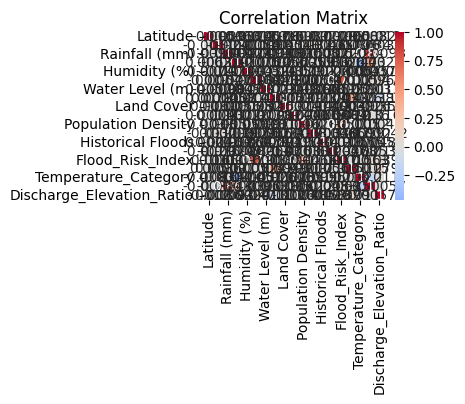

In [18]:
plt.subplot(2, 2, 1)
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')

Text(0.5, 1.0, 'Rainfall Distribution')

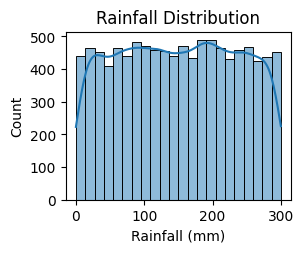

In [19]:
plt.subplot(2, 2, 2)
sns.histplot(df['Rainfall (mm)'], kde=True)
plt.title('Rainfall Distribution')

Text(0.5, 1.0, 'Flood Occurrences')

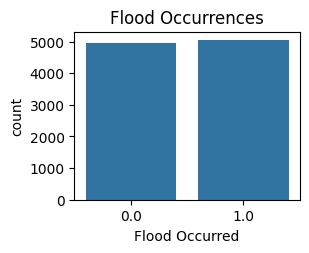

In [20]:
plt.subplot(2, 2, 3)
sns.countplot(x='Flood Occurred', data=df)
plt.title('Flood Occurrences')

Text(0.5, 1.0, 'Elevation vs Flood Risk')

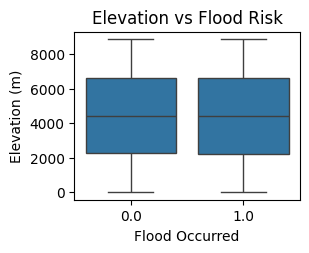

In [21]:
plt.subplot(2, 2, 4)
sns.boxplot(x='Flood Occurred', y='Elevation (m)', data=df)
plt.title('Elevation vs Flood Risk')

In [22]:
plt.tight_layout()
plt.show()

print("\nPreprocessing and feature engineering completed successfully!")

<Figure size 640x480 with 0 Axes>


Preprocessing and feature engineering completed successfully!


2. Model Training: Parallel vs. Non-Parallel Comparison

In [24]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
from multiprocessing import cpu_count
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [25]:
with open('processed_flood_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

Random Forest Implementation

In [26]:
def train_random_forest(n_estimators=100, max_depth=None, n_jobs=1):
    """Train a Random Forest classifier with specified parallelism"""
    start_time = time.time()
    model = RandomForestClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 n_jobs=n_jobs,
                                 random_state=42)
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return model, train_time, accuracy

In [27]:
# Non-parallel Random Forest
print("Training Random Forest (Single-threaded)...")
rf_single, time_single, acc_single = train_random_forest(n_estimators=200, n_jobs=1)

Training Random Forest (Single-threaded)...


In [28]:
# Parallel Random Forest (using all available cores)
print("\nTraining Random Forest (Parallel)...")
rf_parallel, time_parallel, acc_parallel = train_random_forest(n_estimators=200, n_jobs=-1)


Training Random Forest (Parallel)...


In [29]:
# Compare results
print("\nRandom Forest Performance Comparison:")
print(f"Single-threaded - Time: {time_single:.2f}s, Accuracy: {acc_single:.4f}")
print(f"Parallel (n_jobs=-1) - Time: {time_parallel:.2f}s, Accuracy: {acc_parallel:.4f}")
print(f"Speedup: {time_single/time_parallel:.2f}x")


Random Forest Performance Comparison:
Single-threaded - Time: 13.49s, Accuracy: 0.5010
Parallel (n_jobs=-1) - Time: 11.22s, Accuracy: 0.5010
Speedup: 1.20x


In [30]:
def create_sequences(data, targets, window_size=5):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(targets[i+window_size])
    return np.array(X), np.array(y)

In [31]:
# Create sequences
window_size = 5
X_train_seq, y_train_seq = create_sequences(X_train.values, y_train.values, window_size)
X_test_seq, y_test_seq = create_sequences(X_test.values, y_test.values, window_size)

In [32]:
# LSTM Model Architecture
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

In [33]:
# Non-parallel LSTM training (CPU)
print("\nTraining LSTM (CPU - Single-threaded)...")
lstm_cpu = build_lstm_model((window_size, X_train.shape[1]))
start_time = time.time()
history_cpu = lstm_cpu.fit(X_train_seq, y_train_seq,
                          epochs=20,
                          batch_size=32,
                          validation_data=(X_test_seq, y_test_seq),
                          verbose=1)
cpu_time = time.time() - start_time
_, cpu_acc = lstm_cpu.evaluate(X_test_seq, y_test_seq, verbose=0)


Training LSTM (CPU - Single-threaded)...
Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4979 - loss: 0.6948 - val_accuracy: 0.5018 - val_loss: 0.6933
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4962 - loss: 0.6935 - val_accuracy: 0.5103 - val_loss: 0.6936
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5149 - loss: 0.6929 - val_accuracy: 0.4987 - val_loss: 0.6937
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5169 - loss: 0.6921 - val_accuracy: 0.5078 - val_loss: 0.6956
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5300 - loss: 0.6896 - val_accuracy: 0.4977 - val_loss: 0.6989
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5247 - loss: 0.6899 - val_accuracy: 0.4942 - val_loss: 0.7005
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5553 - loss: 0.6823 - val_accuracy: 0.4927 - val_loss: 0.7066
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - a

In [34]:
# Parallel LSTM training (GPU if available)
print("\nTraining LSTM (GPU - Parallel if available)...")
# Configure TensorFlow to use GPU if available
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU for acceleration")

lstm_gpu = build_lstm_model((window_size, X_train.shape[1]))
start_time = time.time()
history_gpu = lstm_gpu.fit(X_train_seq, y_train_seq,
                          epochs=20,
                          batch_size=32,
                          validation_data=(X_test_seq, y_test_seq),
                          verbose=1)
gpu_time = time.time() - start_time
_, gpu_acc = lstm_gpu.evaluate(X_test_seq, y_test_seq, verbose=0)



Training LSTM (GPU - Parallel if available)...
Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.4880 - loss: 0.6951 - val_accuracy: 0.5158 - val_loss: 0.6934
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5147 - loss: 0.6928 - val_accuracy: 0.5028 - val_loss: 0.6939
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5180 - loss: 0.6923 - val_accuracy: 0.4892 - val_loss: 0.6947
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5289 - loss: 0.6909 - val_accuracy: 0.4897 - val_loss: 0.6954
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5447 - loss: 0.6886 - val_accuracy: 0.4812 - val_loss: 0.6995
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5481 - loss: 0.6869 - val_accuracy: 0.4947 - val_loss: 0.7006
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5540 - loss: 0.6827 - val_accuracy: 0.4912 - val_loss: 0.7031
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/s

In [35]:
# Compare results
print("\nLSTM Performance Comparison:")
print(f"CPU (Single-threaded) - Time: {cpu_time:.2f}s, Accuracy: {cpu_acc:.4f}")
if len(physical_devices) > 0:
    print(f"GPU (Parallel) - Time: {gpu_time:.2f}s, Accuracy: {gpu_acc:.4f}")
    print(f"Speedup: {cpu_time/gpu_time:.2f}x")
else:
    print("No GPU available for parallel acceleration")


LSTM Performance Comparison:
CPU (Single-threaded) - Time: 73.48s, Accuracy: 0.4842
No GPU available for parallel acceleration


Visualization of Results

Text(1, 11.717619895935059, '11.22s')

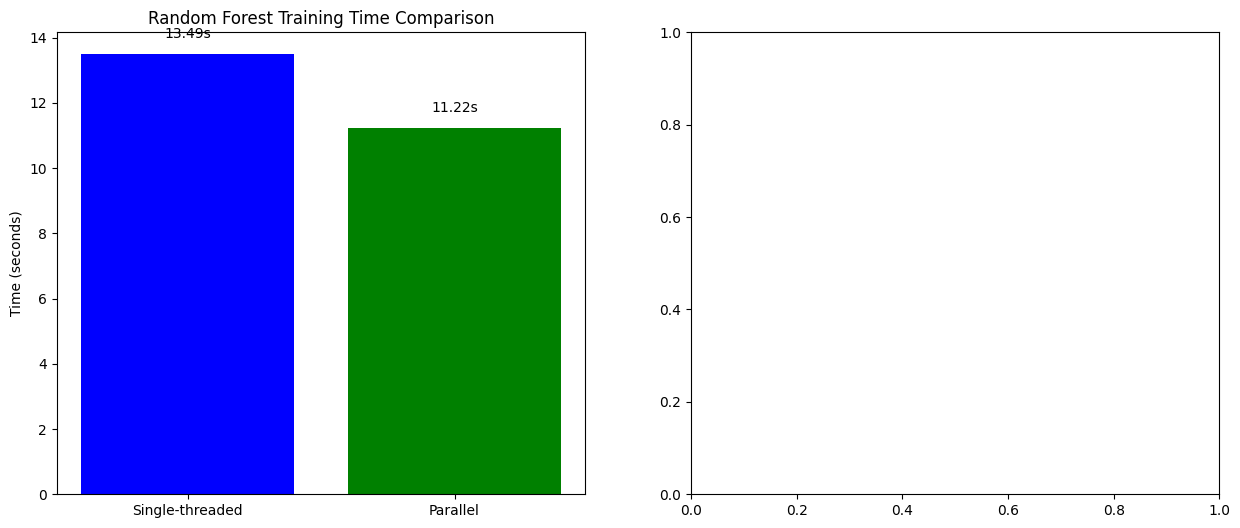

In [36]:
# Random Forest comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# RF timing comparison
ax1.bar(['Single-threaded', 'Parallel'], [time_single, time_parallel], color=['blue', 'green'])
ax1.set_title('Random Forest Training Time Comparison')
ax1.set_ylabel('Time (seconds)')
ax1.text(0, time_single+0.5, f"{time_single:.2f}s", ha='center')
ax1.text(1, time_parallel+0.5, f"{time_parallel:.2f}s", ha='center')

In [37]:
# RF accuracy comparison
ax2.bar(['Single-threaded', 'Parallel'], [acc_single, acc_parallel], color=['blue', 'green'])
ax2.set_title('Random Forest Accuracy Comparison')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
ax2.text(0, acc_single+0.02, f"{acc_single:.4f}", ha='center')
ax2.text(1, acc_parallel+0.02, f"{acc_parallel:.4f}", ha='center')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [38]:
# LSTM comparison (only if GPU was available)
if len(physical_devices) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # LSTM timing comparison
    ax1.bar(['CPU', 'GPU'], [cpu_time, gpu_time], color=['red', 'purple'])
    ax1.set_title('LSTM Training Time Comparison')
    ax1.set_ylabel('Time (seconds)')
    ax1.text(0, cpu_time+0.5, f"{cpu_time:.2f}s", ha='center')
    ax1.text(1, gpu_time+0.5, f"{gpu_time:.2f}s", ha='center')

    # LSTM accuracy comparison
    ax2.bar(['CPU', 'GPU'], [cpu_acc, gpu_acc], color=['red', 'purple'])
    ax2.set_title('LSTM Accuracy Comparison')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1)
    ax2.text(0, cpu_acc+0.02, f"{cpu_acc:.4f}", ha='center')
    ax2.text(1, gpu_acc+0.02, f"{gpu_acc:.4f}", ha='center')

    plt.tight_layout()
    plt.show()

3. Benchmarking & Evaluation

In [57]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [59]:
sns.set(style='whitegrid')

In [60]:
with open('processed_flood_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
def benchmark_model(parallel: bool):
    metrics = {}
    n_jobs = -1 if parallel else 1
    model = RandomForestClassifier(n_estimators=100, n_jobs=n_jobs, random_state=42)

    # Measure training time
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()

    # Measure inference time
    start_infer = time.time()
    y_pred = model.predict(X_test)
    end_infer = time.time()

    # Calculate metrics
    metrics['parallel'] = 'Parallel' if parallel else 'Non-Parallel'
    metrics['training_time'] = end_train - start_train
    metrics['inference_time'] = end_infer - start_infer
    metrics['accuracy'] = accuracy_score(y_test, y_pred)

    return metrics

In [65]:
parallel_metrics = benchmark_model(parallel=True)
non_parallel_metrics = benchmark_model(parallel=False)

In [66]:
results = [non_parallel_metrics, parallel_metrics]

In [67]:
print("\nBenchmark Results:")
for res in results:
    print(f"{res['parallel']}: Training Time = {res['training_time']:.4f}s, "
          f"Inference Time = {res['inference_time']:.4f}s, "
          f"Accuracy = {res['accuracy']:.4f}")


Benchmark Results:
Non-Parallel: Training Time = 5.5426s, Inference Time = 0.0574s, Accuracy = 0.5170
Parallel: Training Time = 7.4538s, Inference Time = 0.1822s, Accuracy = 0.5170


In [68]:
# Visualization
def plot_benchmark(results):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for i, metric in enumerate(['training_time', 'inference_time', 'accuracy']):
        sns.barplot(x='parallel', y=metric, data=results, ax=axs[i], palette='muted')
        axs[i].set_title(f'{metric.replace("_", " ").title()}')
        axs[i].set_ylabel(metric.replace("_", " ").title())
        axs[i].set_xlabel("Mode")

    plt.tight_layout()
    plt.suptitle("Parallel vs Non-Parallel Performance Comparison", fontsize=16, y=1.05)
    plt.show()

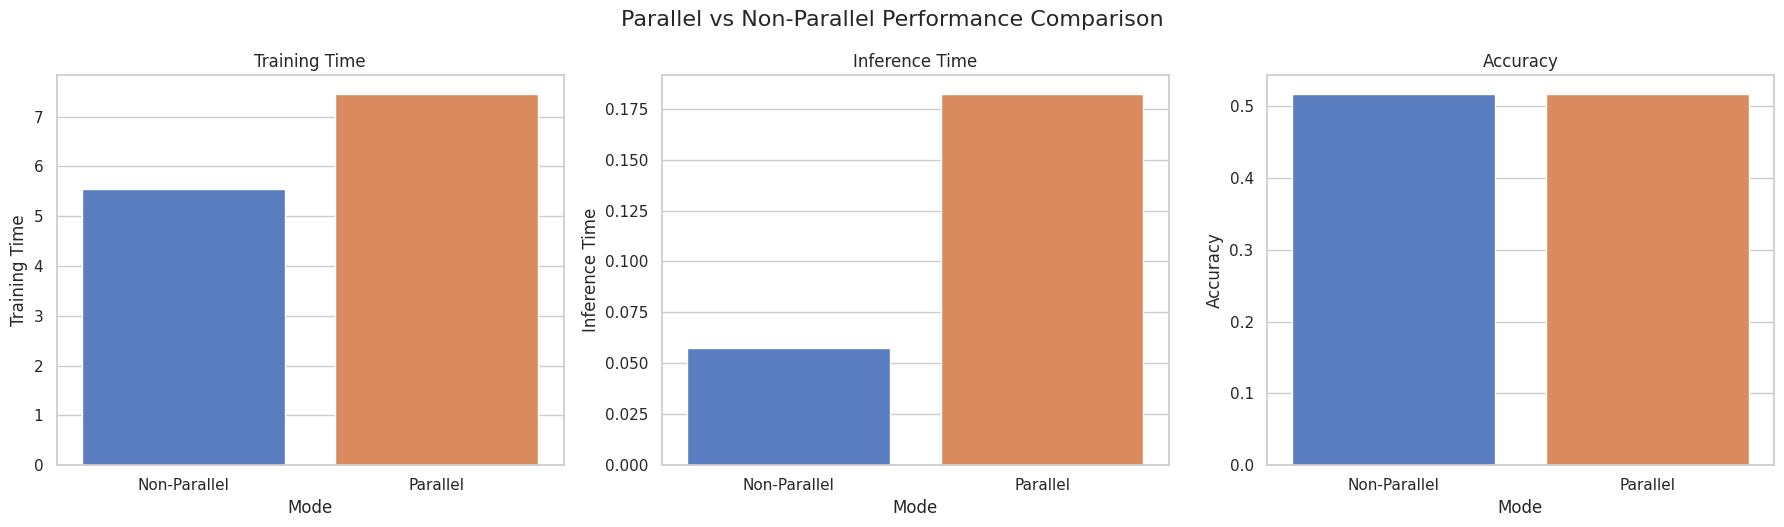

In [69]:
import pandas as pd
plot_benchmark(pd.DataFrame(results))